# Notes

### Impedance matching and Cascode Characterization
- All sweeps are performed with 0.5 GHz - 1.5 GHz range
- Calibration is performed taking into account 2 coax cables used for measurement

In [9]:
import skrf as rf
import matplotlib.pyplot as plt

def show_plot(filename, title_through="S21", title_ret = "S11"):
	ntwk = rf.Network(filename)

	# Convert frequency from Hz to GHz for plotting
	freq_ghz = ntwk.f / 1e9

	# Create a figure and 2 side-by-side subplots
	fig, (ax_s21, ax_s11) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

	# --------------------------
	# Subplot 1: S21
	# --------------------------
	ax_s21_phase = ax_s21.twinx()  # second y-axis for phase

	# Plot S21 magnitude (dB) on the left y-axis
	mag_s21 = ntwk.s21.s_db.flatten()
	ax_s21.plot(freq_ghz, mag_s21, label=f"{title_through} |dB|")
	ax_s21.set_xlabel("Frequency (GHz)")
	ax_s21.set_ylabel("Magnitude (dB)")

	# Plot S21 phase (degrees) on the right y-axis
	phase_s21 = ntwk.s21.s_deg.flatten()
	ax_s21_phase.plot(freq_ghz, phase_s21, label=f"{title_through} Phase (deg)", linestyle="--", color="orange")
	ax_s21_phase.set_ylabel("Phase (degrees)")

	# Combine legends for magnitude and phase in the first subplot
	lines1, labels1 = ax_s21.get_legend_handles_labels()
	lines2, labels2 = ax_s21_phase.get_legend_handles_labels()
	ax_s21.legend(lines1 + lines2, labels1 + labels2, loc="best")

	ax_s21.set_title(f"{title_through} Magnitude & Phase")

	# --------------------------
	# Subplot 2: S11
	# --------------------------
	ax_s11_phase = ax_s11.twinx()  # second y-axis for phase

	# Plot S11 magnitude (dB) on the left y-axis
	mag_s11 = ntwk.s11.s_db.flatten()
	ax_s11.plot(freq_ghz, mag_s11, label=f"{title_ret} |dB|")
	ax_s11.set_xlabel("Frequency (GHz)")
	ax_s11.set_ylabel("Magnitude (dB)")

	# Plot S11 phase (degrees) on the right y-axis
	phase_s11 = ntwk.s11.s_deg.flatten()
	ax_s11_phase.plot(freq_ghz, phase_s11, label=f"{title_ret} Phase (deg)", linestyle="--", color="orange")
	ax_s11_phase.set_ylabel("Phase (degrees)")

	# Combine legends for magnitude and phase in the second subplot
	lines3, labels3 = ax_s11.get_legend_handles_labels()
	lines4, labels4 = ax_s11_phase.get_legend_handles_labels()
	ax_s11.legend(lines3 + lines4, labels3 + labels4, loc="best")

	ax_s11.set_title(f"{title_ret} Magnitude & Phase")

	plt.tight_layout()
	plt.show()

## Check v0
- Initial matching circuit used as received in intial design (so incomplete)

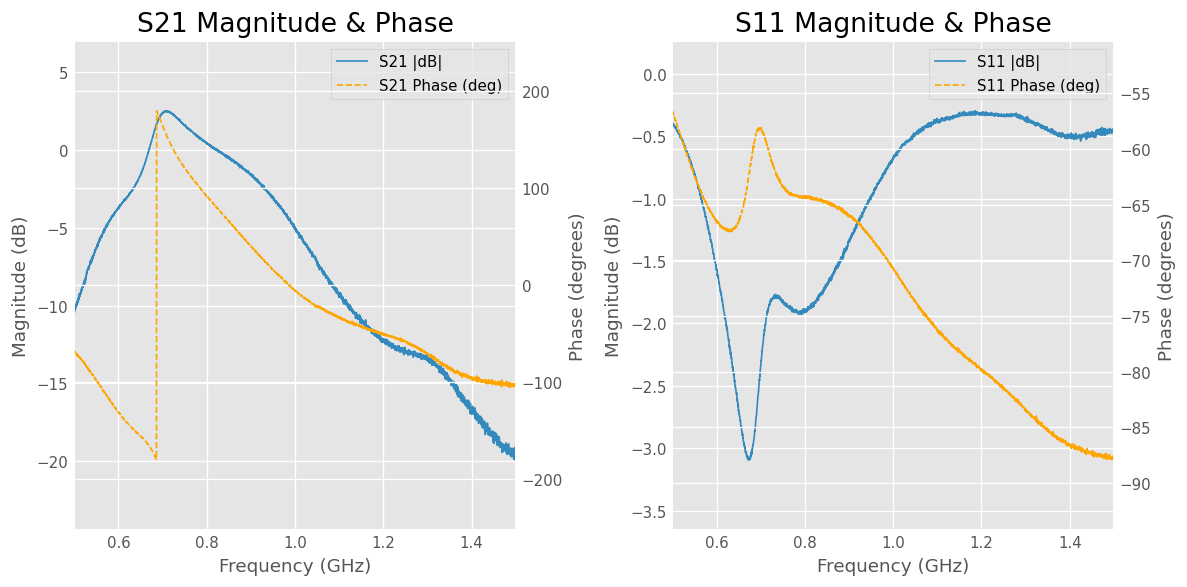

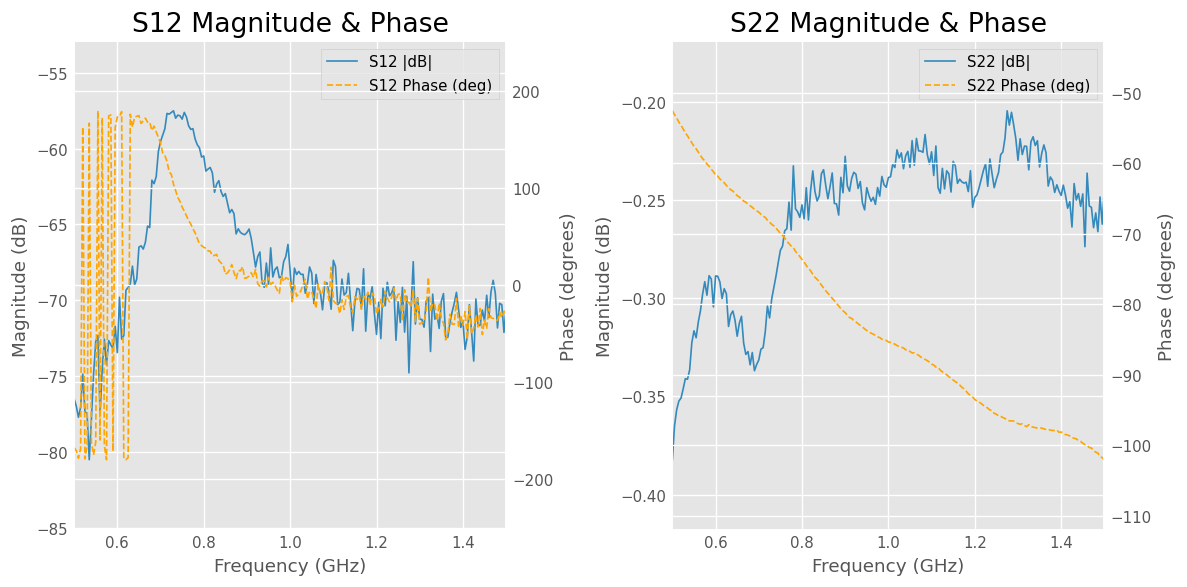

In [10]:

# Load the S-parameter file (Touchstone format).
# Adjust the path/filename as needed:
filename = "data/double_coax_calib_S11_S21_v0.s2p"
show_plot(filename, title_through="S21", title_ret = "S11")
filename = "data/double_coax_calib_S22_S12_v0.s2p"
show_plot(filename, title_through="S12", title_ret = "S22")

### Observation
- It seems like the gain is about 2.5 db at its highest in the current situation
### Next steps
- Remove the 1pF input capacitor (Z2), put a soldering bridge instead
- Remove the 20nH input inductor (Z20)
- Remove the 3.6 pF output capacitor (Z5), replace by a soldering bridge
- We continue measuring only with the short female-to-female connector in between, and drop the coax measurement here since it's likely the least accurate one.


## Check v1

### Done
- Implemented "next steps" from check v0
- Measuring single-port S-parameters

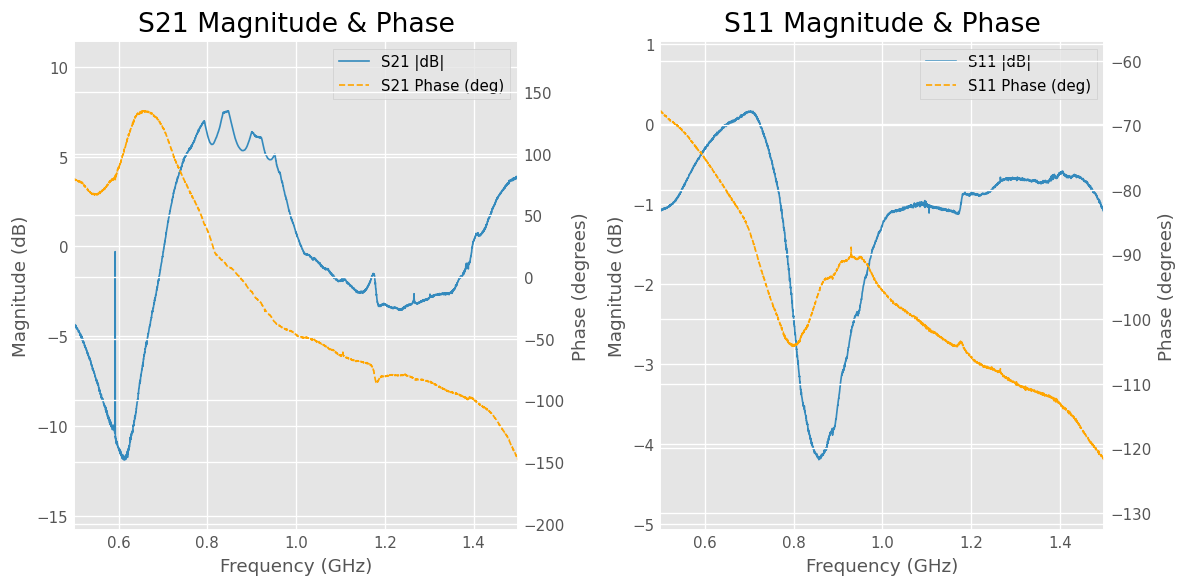

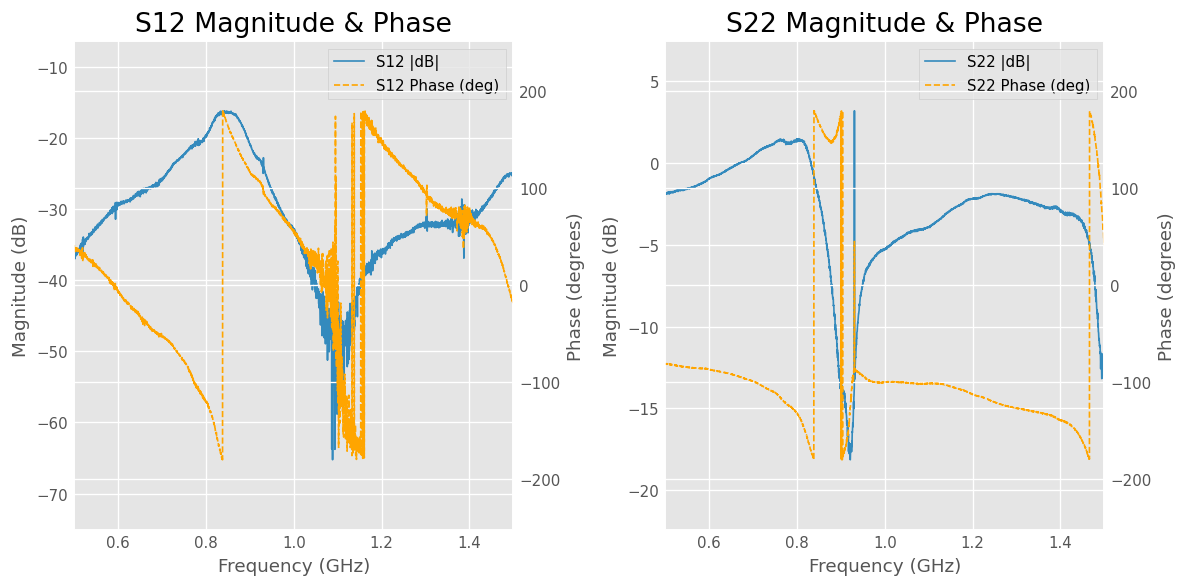

In [11]:

# Load the S-parameter file (Touchstone format).
# Adjust the path/filename as needed:
filename = "data/double_coax_calib_S11_S21_v1.s2p"
show_plot(filename)
filename = "data/double_coax_calib_S22_S12_v1.s2p"
show_plot(filename, title_through="S12", title_ret="S22")

### Observation
- It seems like the highest gain now sticks around 7.5 dB, which is also where the S-parameter is lowest (so the match is best).
### Checking DC operating points
- Check whether transistors are operating in linear mode.
	- It seems like Vb is smaller than Vc in every case, so the transistor is not in saturation.

In [30]:
Vcc = 4.8

### Checking DC Operating point (U7)
DC_VBase_U7 = 0.88			#! SIM VALUE: 1.15 V
DC_VEmitter_U7 = 0.52		#! SIM VALUE: 0.36 V
DC_VCollector_U7 = 1.84		#! SIM VALUE: 1.54 V
DC_IEmitter_U7 = DC_VEmitter_U7 / 47

### Checking DC Operating point (U6)
DC_VBase_U6 = 2.08			#! SIM VALUE: 2.33 V
DC_VEmitter_U6 = 1.84		#! SIM VALUE: 1.54 V
DC_VCollector_U6 = 2.6		#! SIM VALUE: 1.7 V
DC_IEmitter_U6 = DC_IEmitter_U7 # Assumption that Ic = Ie

### Checking DC Operating point (U8)
DC_VBase_U8 = 2.6			#! SIM VALUE: 3.45 V
DC_VEmitter_U8 = 2.32		#! SIM VALUE: 2.64 V
DC_VCollector_U8 = 4.88		#! SIM VALUE: 5 V
DC_IEmitter_U8 = DC_VEmitter_U8 / 200

print(f"VBE - U7 {DC_VBase_U7-DC_VEmitter_U7:.2f} V, U6 {DC_VBase_U6-DC_VEmitter_U6:.2f} V, U8 {DC_VBase_U8-DC_VEmitter_U8:.2f} V")
print(f"VCE - U7 {DC_VCollector_U7-DC_VEmitter_U7:.2f} V, U6 {DC_VCollector_U6-DC_VEmitter_U6:.2f} V, U8 {DC_VCollector_U8-DC_VEmitter_U8:.2f} V")
print(f"IE  - U7 {DC_IEmitter_U7*1000:.2f} mA, U6 {DC_IEmitter_U6*1000:.2f} mA, U8 {DC_IEmitter_U8*1000:.2f} mA")

VBE - U7 0.36 V, U6 0.24 V, U8 0.28 V
VCE - U7 1.32 V, U6 0.76 V, U8 2.56 V
IE  - U7 11.06 mA, U6 11.06 mA, U8 11.60 mA


## Matching
- Take the 2 .s2p s-parameter files and merge them together to get the full s2p-parameter files.
- Calculate the correct matching circuit using SimNEC.

### Merging the s2p files

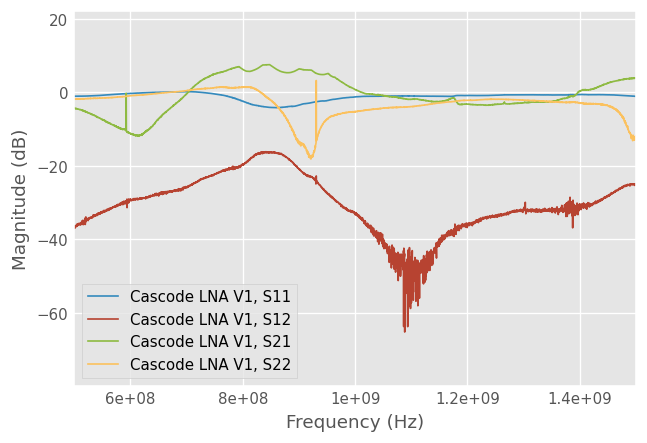

In [43]:
import skrf as rf
rf.stylely()

# Load partial networks
mrf = rf.Network('data/double_coax_calib_S11_S21_v1.s2p')
tmp_output = rf.Network('data/double_coax_calib_S22_S12_v1.s2p')

# Copy data from the reverse measurement into the model
mrf.s[:,0,1] = tmp_output.s[:,1,0]
mrf.s[:,1,1] = tmp_output.s[:,0,0]
mrf.name = "Cascode LNA V1"

# Plot figure as sanity check and save to new file
mrf.plot_s_db()
mrf.write_touchstone('data/double_coax_calib_full_v1.s2p')

### Scikit-RF
- Input here had a 3.6 pF capacitor (Z4)
- Output here had a 3.6 pF capacitor (Z5)
- Add the relevant transmission line impedance acquired from the board

#### Usefull functions

In [24]:
import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### NETWORK BUILDING FUNCTIONS
def build_LNA_match_network(C1_val, L1_val, C2_val, L2_val, freq, band_ntwk, z0=50):
    # Media
    line = DefinedGammaZ0(frequency=freq, z0=z0, gamma=0j)  # zero gamma => ideal lumps

    # Lumped elements
    C1_SE  = line.capacitor(C1_val, frequency=freq, name='C1_SE')
    L1_SH = line.inductor(L1_val, frequency=freq, name='L1_SH')
    C2_SE  = line.capacitor(C2_val, frequency=freq, name='C2_SE')
    L2_SH = line.inductor(L2_val, frequency=freq, name='L2_SH')
    PORTIN = rf.Circuit.Port(frequency=freq, name='PORTIN', z0=z0)
    PORTOUT = rf.Circuit.Port(frequency=freq, name='PORTOUT', z0=z0)
    GND  = rf.Circuit.Ground(frequency=freq, name='GND', z0=z0)
    
    # Node connections
    connections = [
        [(PORTIN, 0),  (C1_SE, 0)],
        [(C1_SE, 1), (L1_SH, 0), (band_ntwk, 0)],
        [(C2_SE, 0), (L2_SH, 0), (band_ntwk, 1)],
        [(L2_SH, 1), (L1_SH, 1), (GND, 0)],
        [(PORTOUT, 0),  (C2_SE, 1)]
    ]

    ckt = rf.Circuit(connections, name='LNA-match', frequency=freq)
    return ckt

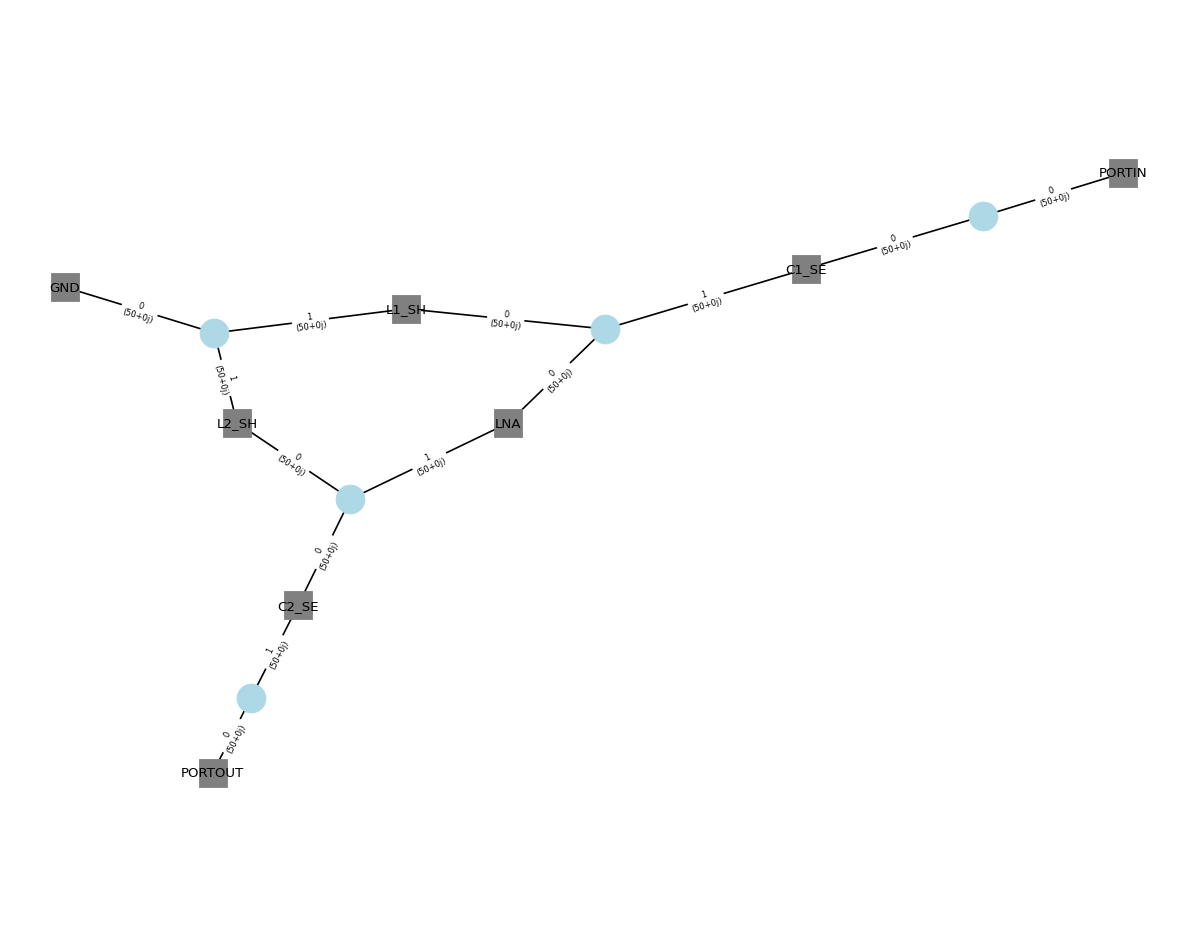

In [27]:
import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize

fname = 'data/double_coax_calib_full_v1.s2p'
antenna_ntwk = rf.Network(fname)
antenna_ntwk.name = 'LNA'

# Band restriction
Z0 = 50
f_low, f_high = 860e6, 1200e6 #! Matching range
band_ntwk = antenna_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  # scikit-rf Frequency object
C1_val = 1e-12
L1_val = 1e-9
C2_val = 1e-12
L2_val = 1e-9

# **************** CIRCUIT *************
ntwk = build_LNA_match_network(C1_val, L1_val, C2_val, L2_val, freq, band_ntwk)

ntwk.plot_graph(network_labels=True, network_fontsize=8,
               port_labels=True, port_fontsize=8,
              edge_labels=True, edge_fontsize=5)


### Max gain and stability
Check theoretically [maximum available gain](https://www.microwaves101.com/encyclopedias/stability-factor) to check whether the issue might in fact be the LNA itself.
ONLY in cases where the amplifier is unconidtionally stable (K>=1), the maximum stable gain is an [attribute](https://scikit-rf.readthedocs.io/en/latest/api/generated/skrf.network.Network.max_gain.html#skrf.network.Network.max_gain) of the Network-property.

However most of the time the desired matching at the input is for lowest noise increase (not max power), and output for max power.

#### Rollet factor

First thing to check, shows whether the amplifier is unconditionally stable (K>=1) or maybe there is an issue somewhere (<1).
If there is an issue, to check the region where instability might happen, check stability circles and rollet.

#### $\mu$-factor

- The mu-factor is the distance from the center of the Smith-Chart to the nearest potential unstable point on the input source plane.
- The mu'-factor is the distance from the center of the smith-chart to the nearest potentially unstable point on the output load plane.

[Link to explanation](https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Electronics/Microwave_and_RF_Design_V%3A_Amplifiers_and_Oscillators_(Steer)/02%3A_Linear_Amplifiers/2.06%3A_Amplifier_Stability)

#### Stability circle interpretation

For the derivation of the input and output stability circles we:
- Writing the input coefficient as a function of the S-parameters and the load.
- Writing the output coefficient as a function fo the S-parameters and the source.

The condition is set that they both need to be <= 1 (otherwise you'd have positive feedback and oscillations, since the input / output reflection would be greater than the input / output power).

Input / output reflection = 1 is the stability boundary, replacing that creates 2 circular equations showing the boundaries of stability for input / output devices in function of the output source (output reflection) and input load (input reflections) respectively.
- The input circle is the boundary region where the reflection becomes > 1 (unstable) for a $\Gamma_{S}$.
- The output circle is the boundary region where the reflection becomes > 1 (unstable) for a $\Gamma_{L}$.
	- $\Gamma_{S}$, $\Gamma_{L}$ being the source reflection coefficient as displayed below.

[Link to explanation](https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Electronics/Microwave_and_RF_Design_V%3A_Amplifiers_and_Oscillators_(Steer)/02%3A_Linear_Amplifiers/2.06%3A_Amplifier_Stability), [Link to scikit-RF docs](https://scikit-rf.readthedocs.io/en/latest/api/generated/skrf.network.Network.stability_circle.html)

**Checking for stability**

Best way to check for stability is 
1. Check stability at 50 ohms for input and output.
2. See if that falls inside / outside the stability circle.
3. Based on that classify the region as stable / unstable.

<img src="data/amplifier_configuration.png" alt="drawing" width="800"/>

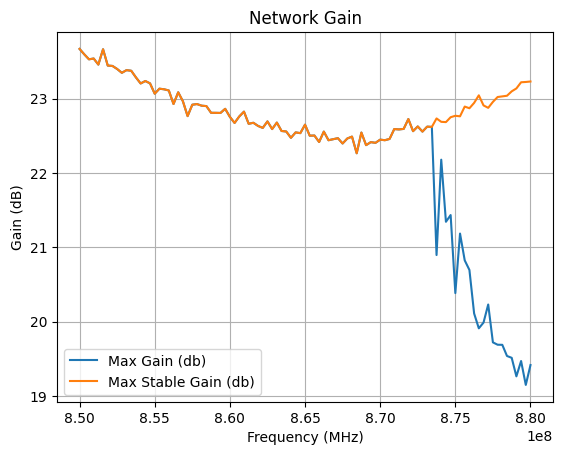

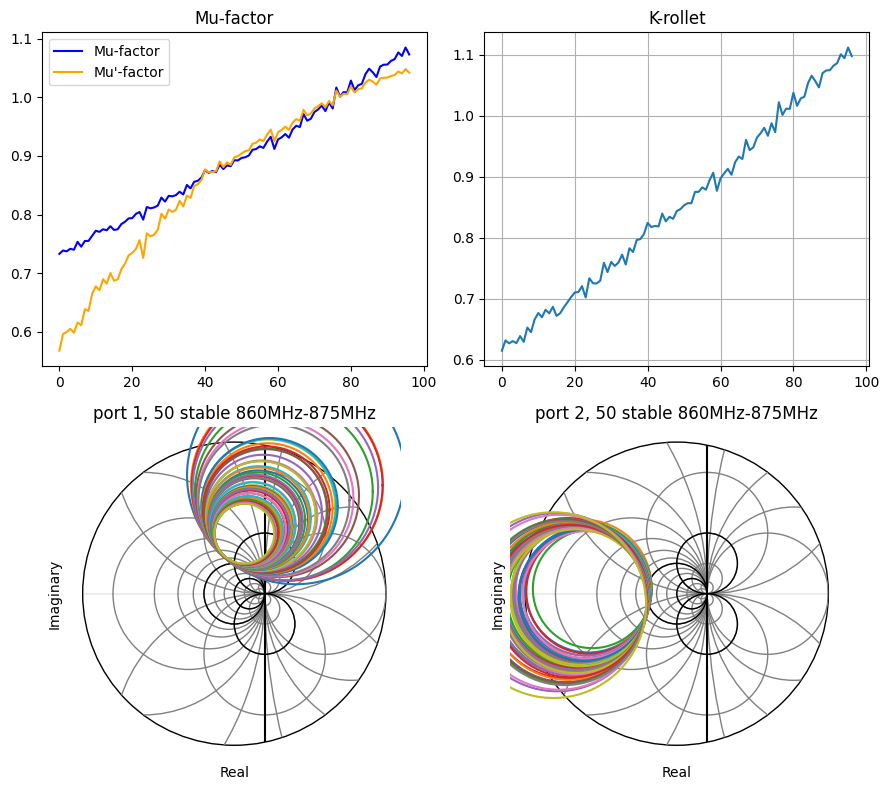

In [26]:
import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize

fname = 'data/double_coax_calib_full_v1.s2p'
cascode_ntwk = rf.Network(fname)
cascode_ntwk.name = 'LNA'  # give it a name for circuit connections

f_low, f_high = 850e6, 880e6 #! Matching range
band_ntwk = cascode_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  # scikit-rf Frequency object

delta = band_ntwk.s11.s * band_ntwk.s22.s - band_ntwk.s12.s * band_ntwk.s21.s
mu_factor = (1 - np.abs(band_ntwk.s11.s) ** 2) / (np.abs(band_ntwk.s22.s - np.conjugate(band_ntwk.s11.s) * delta) + np.abs(band_ntwk.s12.s * band_ntwk.s21.s))
mu_dash_factor = (1 - np.abs(band_ntwk.s22.s) ** 2) / (np.abs(band_ntwk.s11.s - np.conjugate(band_ntwk.s22.s) * delta) + np.abs(band_ntwk.s12.s * band_ntwk.s21.s))


### Maximum possible gain
plt.plot(freq.f_scaled, 20*np.log10(np.abs(band_ntwk.max_gain).flatten()), label='Max Gain (db)')
plt.plot(freq.f_scaled, 20*np.log10(np.abs(band_ntwk.max_stable_gain).flatten()), label='Max Stable Gain (db)')
plt.xlabel(f"Frequency (MHz)")
plt.ylabel("Gain (dB)")
plt.title("Network Gain")
plt.grid(True)
plt.legend()
plt.show()


### Plotting
freq_range = '860MHz-875MHz'
lsc_portin = cascode_ntwk[freq_range].stability_circle(target_port=0)
lsc_portout = cascode_ntwk[freq_range].stability_circle(target_port=1)

# Check whether the region inside or outside the stability circle is stable

### Stability circle  (Focus on the lorawan frequency band)
S11_max = np.max(np.abs(band_ntwk.s11.s))
S22_max = np.max(np.abs(band_ntwk.s22.s))

title_portin = "port 1, 50 stable"
if (S11_max > 1):
	title_portin = "port 1, 50 unstable"

# Check whether the region inside or outside the stability circle is stable
title_portout = "port 2, 50 stable"
if (S22_max > 1):
	title_portout = "port 2, 50 unstable"

fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222); ax2.grid()
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224); ax4.grid()

ax1.title.set_text('Mu-factor')
ax2.title.set_text('K-rollet')

ax1.plot( mu_factor.flatten(), label='Mu-factor', color='blue')
ax1.plot( mu_dash_factor.flatten(), label='Mu\'-factor', color = 'orange')
ax1.legend(loc='upper left')
ax2.plot( np.array(band_ntwk.stability).flatten(),label = 'K-stability factor')
rf.plotting.plot_smith(s=lsc_portin, title=title_portin + " "  +freq_range, smith_r=5, ax=ax3, draw_labels=True)
rf.plotting.plot_smith(s=lsc_portout, title=title_portout + " "  + freq_range, smith_r=5, ax=ax4, draw_labels=True)
fig.tight_layout()

plt.show()

For certain frequencies in the desired range there is instability. When going lower than 860 MHz there is instability virtually everywhere. Perhaps some damping is in order

### Matching

Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -3.1368036222506106
       x: [ 7.472e-12  7.726e-09  1.500e-11  7.833e-09]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [-3.322e-13 -1.080e-11 -3.322e-13 -1.026e-09]
           [ 7.527e-12  2.447e-10  7.527e-12 -9.902e-11]]
    nfev: 101
C1 = 7.472 pF, Optimal L1 = 7.726 nH, Optimal C2 = 15.000 pF, Optimal L2 = 7.833 nH


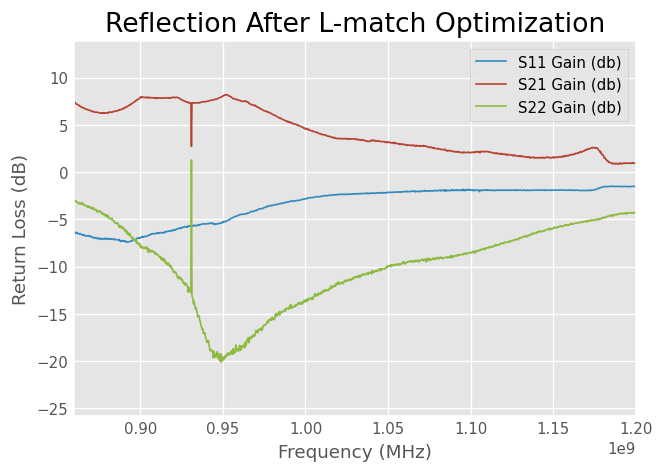

In [ ]:
import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize


fname = 'data/double_coax_calib_full_v1.s2p'
antenna_ntwk = rf.Network(fname)
antenna_ntwk.name = 'LNA'  # give it a name for circuit connections

# Restrict to band
Z0 = 50
f_low, f_high = 860e6, 1200e6 #! Matching range
band_ntwk = antenna_ntwk[f'{f_low}-{f_high}']
freq = band_ntwk.frequency  # scikit-rf Frequency object

# Set initial value for
C1_val = 3.6e-12
L1_val = 7.6e-9
C2_val = 3.6e-12
L1_val = 7.6e-9


# Optimization objective
def objective_LC(x, freq, band_ntwk, z0=50):
    C1, L1, C2, L2 = x
    # penalize invalid or negative values
    if np.any(np.array([C1, L1, C2, L2]) <= 0):
        return 1e9  # large penalty
    
    # Build the circuit
    net = build_LNA_match_network(C1, L1, C2, L2, freq, band_ntwk, z0).network
    # Evaluate S11 magnitude (vector over freq)
    s11_mag = net.s11.s_mag
    s22_mag = net.s22.s_mag
    s21_mag = net.s21.s_mag
    # np.mean(s11_mag**2) + np.mean(s22_mag**2) - 
    # Return mean power reflection
    return -np.mean(s21_mag**2)

# RUN OPTIMIZATION
L_min, L_max = 0.05e-9, 20e-9    # 0.1 to 20 nH
C_min, C_max = 0.05e-12, 15e-12  # 0.1 to 10 pF
initial_guess = [C1_val, L1_val, C2_val, L2_val]
bounds = [(C_min, C_max), (L_min, L_max), (C_min, C_max), (L_min, L_max)]

res = minimize(
    objective_LC,
    x0=initial_guess,
    args=(freq, band_ntwk, Z0),
    method='Powell',
    bounds=bounds
)

opt_C1, opt_L1, opt_C2, opt_L2 = res.x
print("Optimization result:", res)
print(f"C1 = {opt_C1*1e12:.3f} pF, Optimal L1 = {opt_L1*1e9:.3f} nH, Optimal C2 = {opt_C2*1e12:.3f} pF, Optimal L2 = {opt_L2*1e9:.3f} nH")

# PLOT
final_match = build_LNA_match_network(opt_C1, opt_L1, opt_C2, opt_L2, freq, band_ntwk, Z0).network
s11_opt = final_match.s11
s21_opt = final_match.s21
s22_opt = final_match.s22

plt.plot(freq.f_scaled, 20*np.log10(np.abs(s11_opt.s).flatten()), label='S11 Gain (db)')
plt.plot(freq.f_scaled, 20*np.log10(np.abs(s21_opt.s).flatten()), label='S21 Gain (db)')
plt.plot(freq.f_scaled, 20*np.log10(np.abs(s22_opt.s).flatten()), label='S22 Gain (db)')
plt.xlabel(f"Frequency (MHz)")
plt.ylabel("Return Loss (dB)")
plt.title("Reflection After L-match Optimization")
plt.grid(True)
plt.legend()
plt.show()

# Sources
- [S-parameter simulation and matching of a 2-port DUT](https://www.youtube.com/watch?v=HXsZhVdLLDM&ab_channel=EEStream)
- [Noise figure measurements using a NanoVNA](https://groups.io/g/nanovna-users/topic/preamp_noise_figure_nf/34392557)
	- I'll need to buy a noise source if I want to measure noise using a NanoVNA (Y-factor test with calibrated noise diode)